In [2]:
import matplotlib.pyplot as plot
import pandas as pd
import pandas.io.json as pj
import psycopg2
import os

In [31]:
conn = psycopg2.connect(os.environ.get('PROMSQL_CONNSTR'))
samples = pd.read_sql_query("SELECT * FROM metrics WHERE name = 'node_load1' ORDER BY time DESC LIMIT 5000", conn)
conn.close()

In [32]:
print(samples.head(5))

                     time        name                                   lid  \
0 2019-12-22 16:17:38.773  node_load1  00000000-0000-0000-c72f-e6f5a4e3c40d   
1 2019-12-22 16:17:15.960  node_load1  00000000-0000-0000-c427-eda394ef86f7   
2 2019-12-22 16:17:13.634  node_load1  00000000-0000-0000-fefb-afdad721ccf7   
3 2019-12-22 16:17:11.524  node_load1  00000000-0000-0000-52cd-53a87966e648   
4 2019-12-22 16:17:08.773  node_load1  00000000-0000-0000-c72f-e6f5a4e3c40d   

   value                                             labels  
0   0.09  {'job': 'node-exporter', 'pod': 'node-exporter...  
1   0.60  {'job': 'node-exporter', 'pod': 'node-exporter...  
2   1.46  {'job': 'node-exporter', 'pod': 'node-exporter...  
3   0.66  {'job': 'node-exporter', 'pod': 'node-exporter...  
4   0.15  {'job': 'node-exporter', 'pod': 'node-exporter...  


In [48]:
labels = pj.json_normalize(samples['labels'])
nodes = labels[['instance']].replace(r':\d+', '', regex=True)
load = (samples.join(nodes).drop(columns=['labels']))

In [49]:
print(load.head(5))

                     time        name                                   lid  \
0 2019-12-22 16:17:38.773  node_load1  00000000-0000-0000-c72f-e6f5a4e3c40d   
1 2019-12-22 16:17:15.960  node_load1  00000000-0000-0000-c427-eda394ef86f7   
2 2019-12-22 16:17:13.634  node_load1  00000000-0000-0000-fefb-afdad721ccf7   
3 2019-12-22 16:17:11.524  node_load1  00000000-0000-0000-52cd-53a87966e648   
4 2019-12-22 16:17:08.773  node_load1  00000000-0000-0000-c72f-e6f5a4e3c40d   

   value    instance  
0   0.09  10.2.1.201  
1   0.60  10.2.1.192  
2   1.46  10.2.1.193  
3   0.66  10.2.1.200  
4   0.15  10.2.1.201  


In [50]:
iload = load.groupby(['lid'])
print(iload.describe())

                                      value                                    \
                                      count      mean       std   min     25%   
lid                                                                             
00000000-0000-0000-52cd-53a87966e648  719.0  0.799736  0.369141  0.21  0.5600   
00000000-0000-0000-c427-eda394ef86f7  720.0  1.438722  1.024509  0.27  0.8775   
00000000-0000-0000-c72f-e6f5a4e3c40d  720.0  0.402778  0.325359  0.00  0.1700   
00000000-0000-0000-fefb-afdad721ccf7  720.0  2.052569  0.588632  0.91  1.6000   

                                                           
                                       50%     75%    max  
lid                                                        
00000000-0000-0000-52cd-53a87966e648  0.70  0.9100   2.49  
00000000-0000-0000-c427-eda394ef86f7  1.20  1.6525  13.02  
00000000-0000-0000-c72f-e6f5a4e3c40d  0.29  0.5525   1.70  
00000000-0000-0000-fefb-afdad721ccf7  1.96  2.4300   4.55  


In [51]:
tload = pd.pivot(load, index='time', columns='instance', values='value').resample('1min').max()
print(tload.head(2))

instance             10.2.1.192  10.2.1.193  10.2.1.200  10.2.1.201
time                                                               
2019-12-22 10:17:00        0.91        1.84         NaN         NaN
2019-12-22 10:18:00        0.78        2.01        0.69        1.39


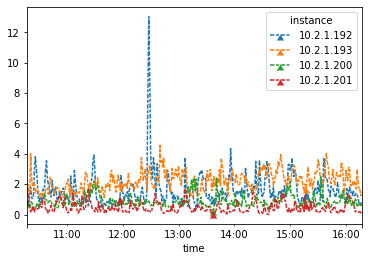

In [54]:
%matplotlib inline
tload.plot.line(linestyle='dashed', dashes=[3.0, 1.0, 2.0, 1.0], marker=6, markevery=100, subplots=False)